In [1]:
# potrzebne importy
import keras
import tensorflow as tf
import numpy as np
import os

from keras import models, layers, losses, callbacks
from keras_cv import layers as layers_cv
from keras.utils import to_categorical
from tensorflow import train
from matplotlib import pyplot as plt
from random import sample

c:\Users\micha\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# wczytanie danych
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# rozmiar obrazków ze zbioru
SIZE = 32

# operacje w ramach augmentacji danych - część modelu
augmentation = models.Sequential()
augmentation.add(layers.RandomFlip(mode='horizontal'))
augmentation.add(layers_cv.RandomCropAndResize(
    target_size=(SIZE, SIZE),
    crop_area_factor=(0.8, 1.0),
    aspect_ratio_factor=(0.9, 1.1)
))

augmentation.add(layers.Normalization(mean=0, variance=1))
augmentation.trainable = False

In [3]:
# procedura zamieniająca batch obrazów na batch sekwencji patchy
def patchify(images_batch, patch_size):
    patches = tf.image.extract_patches(
        images=images_batch,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    patch_dims = patches.shape[-1]
    num_patches = (SIZE // patch_size) ** 2
    patches = tf.reshape(patches, (-1, num_patches, patch_dims))

    return patches

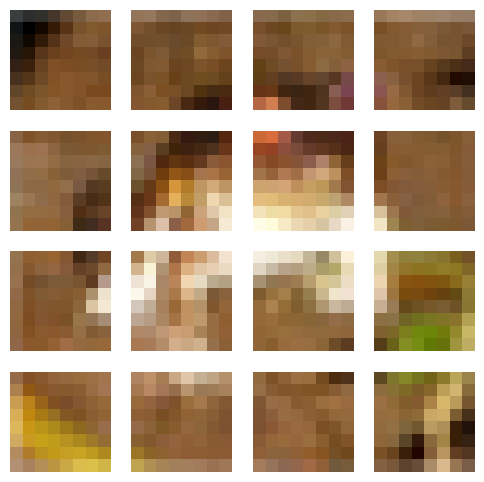

In [4]:
# wizualizacja patchy dla przykładowego obrazka
patches = patchify([x_train[0]], patch_size=8)[0]
dim = np.sqrt(patches.shape[0]).astype(np.uint32)
_, ax = plt.subplots(dim, dim, figsize=(6, 6))

for i in range(patches.shape[0]):
    ax[i//dim][i%dim].imshow(tf.reshape(patches[i], (8, 8, 3)))
    ax[i//dim][i%dim].axis('off')

plt.show()

In [5]:
# pomocnicze zdefiniowanie bloku transformera
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim=256, num_heads=8, mlp_dim=512, dropout_rate=0.2):
        super(TransformerBlock, self).__init__()

        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.mlp_dim = mlp_dim
        self.dropout_rate = dropout_rate

        # blok self-attention
        self.norm1 = layers.LayerNormalization()
        self.attention = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads
        )

        # blok MLP
        self.norm2 = layers.LayerNormalization()
        self.dense1 = layers.Dense(units=self.mlp_dim, activation='gelu')
        self.drop1 = layers.Dropout(rate=self.dropout_rate)
        self.dense2 = layers.Dense(units=self.embed_dim)
        self.drop2 = layers.Dropout(rate=self.dropout_rate)


    def call(self, input, training=False):
        x1 = self.norm1(input)
        x1 = self.attention(x1, x1)

        # połączenie rezydualne
        x1 = layers.Add()([x1, input])

        x2 = self.norm2(x1)
        x2 = self.dense1(x2)
        x2 = self.drop1(x2, training=training)
        x2 = self.dense2(x2)
        x2 = self.drop2(x2, training=training)

        # połączenie rezydualne
        output = layers.Add()([x2, x1])

        return output


# pomocnicze zdefiniowanie funkcji `patchify` jako warstwy
class PatchifyLayer(layers.Layer):
    def __init__(self, patch_size):
        super(PatchifyLayer, self).__init__()

        self.patch_size = patch_size


    def call(self, input):
        return patchify(input, self.patch_size)


# pomocnicze zdefiniowanie class token'a jako warstwy
class ClassTokenLayer(layers.Layer):
    def __init__(self, class_token):
        super(ClassTokenLayer, self).__init__()

        self.class_token = class_token


    def call(self, input):
        batch_size = tf.shape(input)[0]
        class_token_batch = tf.tile(self.class_token, [batch_size, 1, 1])

        return layers.concatenate([class_token_batch, input], axis=1)

In [6]:
# funkcja budująca pełny model według opisu zadania
def build_model(patch_size=4, num_transformer_blocks=6, num_classes=10):
    # liczba patchy
    num_patches = (SIZE // patch_size) ** 2

    # warstwa positional embedding
    positional_embedding = tf.Variable(
        initial_value=tf.random.normal(shape=(1, num_patches + 1, 256)),
        trainable=True,
        name='positional_embedding'
    )

    # class token
    class_token = tf.Variable(
        initial_value=tf.random.normal(shape=(1, 1, 256)),
        trainable=True,
        name='class_token'
    )

    input = layers.Input(shape=(SIZE, SIZE, 3,))

    # augmentacja
    x = augmentation(input)

    # cięcie na patche
    x = PatchifyLayer(patch_size)(x)

    # embedding patchy
    x = layers.Dense(units=256)(x)

    # dodanie class token'a (na pozycji zerowej)
    x = ClassTokenLayer(class_token)(x)

    # dodanie positional embedding
    x = x + positional_embedding

    # dropout
    x = layers.Dropout(rate=0.2)(x)

    # 6 bloków transformera
    for i in range(num_transformer_blocks):
        x = TransformerBlock()(x)

    # ekstrakcja class token'a
    class_token_output = x[:, 0, :]

    # normalizacja warstwy
    x = layers.LayerNormalization()(class_token_output)

    # warstwa wyjściowa modelu
    output = layers.Dense(units=num_classes, activation='softmax')(x)

    # stworzenie modelu i zwrócenie go
    model = models.Model(inputs=input, outputs=output)

    return model

In [7]:
# stworzenie modelu
model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patchify_layer (PatchifyLayer)  │ (None, 64, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64, 256)        │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_token_layer               │ (None, 65, 256)        │             0 │
│ (ClassTokenLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 65, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 65, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 65, 256)        │       527,104 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 65, 256)        │       527,104 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 65, 256)        │       527,104 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 65, 256)        │       527,104 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 65, 256)        │       527,104 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, 65, 256)        │       527,104 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_12          │ (None, 256)            │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,178,250 (12.12 MB)

 Trainable params: 3,178,250 (12.12 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# przygotowanie danych
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [9]:
# parametry związane z epokami
num_epochs = 160
lr_sched1 = 100
lr_sched2 = 150

# zmienna przechowująca epokę ostatnio zapisanego modelu
last_epoch = tf.Variable(0, dtype=tf.int32)

# używany optymalizator
optimizer = keras.optimizers.AdamW()

In [10]:
# folder, w którym będą zapisywane checkpointy modeli
os.makedirs("./checkpoints", exist_ok=True)

# korzystam z checkpointu do zapisywania stanu modelu i optymalizatorów
checkpoint = train.Checkpoint(
    optimizer=optimizer,
    model=model,
    epoch=last_epoch
)

checkpoint_manager = train.CheckpointManager(
    checkpoint=checkpoint,
    directory="./checkpoints",
    max_to_keep=1
)

In [11]:
# wczytywanie stanu
checkpoint.restore(checkpoint_manager.latest_checkpoint)

if checkpoint_manager.latest_checkpoint:
    print(f"Wczytano stan modelu z {checkpoint_manager.latest_checkpoint}")
    last_epoch_num = last_epoch.numpy()
else:
    print("Nie znaleziono checkpointu modelu!")
    last_epoch_num = 0

num_epochs -= last_epoch_num
lr_sched1 -= last_epoch_num
lr_sched2 -= last_epoch_num
print(f"Epoka treningu: {last_epoch_num}, pozostało {num_epochs} epok treningu modelu.")

Wczytano stan modelu z ./checkpoints\ckpt-160
Epoka treningu: 160, pozostało 0 epok treningu modelu.


In [12]:
# skompilowanie modelu
model.compile(
    optimizer=optimizer,
    loss=losses.CategoricalCrossentropy(),
    jit_compile=False
)

In [13]:
# definicja schedulera dla learning rate
def scheduler(epoch, learning_rate):
    if epoch in [lr_sched1, lr_sched2]:
        return 0.1 * learning_rate
    else:
        return learning_rate

# ustawienie schedulera jako callback
callback_lr = callbacks.LearningRateScheduler(scheduler)

In [14]:
# callback do zapisywania modelu na koniec epoki
class CallbackModelSave(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        last_epoch.assign(last_epoch_num + epoch + 1)
        checkpoint_manager.save()

callback_ms = CallbackModelSave()

In [15]:
# trening modelu
model.fit(x_train, y_train, epochs=num_epochs, callbacks=[callback_lr, callback_ms])

In [16]:
# ewaluacja modelu
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - loss: 2.1125


2.112536668777466

In [17]:
# mapowanie numerów klas na nazwy klas, na podstawie: https://www.cs.toronto.edu/~kriz/cifar.html
classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


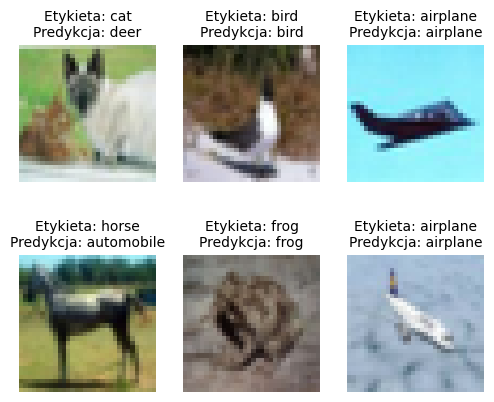

In [18]:
# wybieram losowo 6 obrazków ze zbioru testowego
idxs = sample(range(y_test.shape[0]), 6)
images = x_test[idxs]
true_labels = [classes[arg[1]] for arg in np.argwhere(y_test[idxs])]

# predykcja sieci
predicted_labels = model.predict(images)
predicted_labels = [classes[pred.argmax()] for pred in predicted_labels]

_, ax = plt.subplots(2, 3, figsize=(6, 5))

# przedstawienie obrazków wraz z etykietami i predykcjami
for i, (image, true_label, predicted_label) in enumerate(zip(images, true_labels, predicted_labels)):
    ax[i//3][i%3].imshow(image)
    ax[i//3][i%3].set_title(f"Etykieta: {true_label}\nPredykcja: {predicted_label}", fontsize=10)
    ax[i//3][i%3].axis('off')